## Loading the Test and Train datasets

In [1]:
# Loaded variable 'df' from URI: c:\Users\james\OneDrive\Documents\GitHub\Kaggle-Competitions\Predicting Student Test Scores\data.csv
import pandas as pd
test = pd.read_csv(r'c:\Users\james\OneDrive\Documents\GitHub\Kaggle-Competitions\Predicting Student Test Scores\test.csv')
train = pd.read_csv(r'c:\Users\james\OneDrive\Documents\GitHub\Kaggle-Competitions\Predicting Student Test Scores\train.csv')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [2]:
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


Lots of catagorical variables

exam_score is float

## EDA

In [3]:
train.shape

(630000, 13)

In [4]:
train.columns

Index(['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')

In [5]:
# Data types and missingness
display(train.dtypes)
train.isna().sum().sort_values(ascending=False)

id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [6]:
# summary stats
train.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


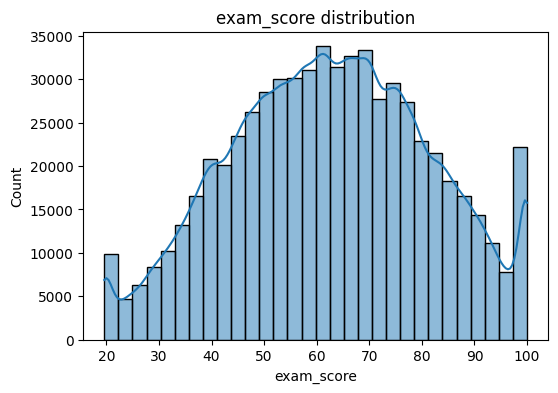

In [7]:
# target distributions

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(train["exam_score"], bins=30, kde=True)
plt.title("exam_score distribution")
plt.show()

Looks like a normal distibution, with the majority of scores from 50 to 70. Its interesting to note that the last bin represening around the 97-100 score mark is an outlier due to its surprisingly high count compared to the previous bins. This could indicate that more people are all 100 score than other scores as this is a limit, people are more likely to hit the limit than an abritrary number inbetween.

In [8]:
# Correlations - nums

num_cols = train.select_dtypes(include="number").columns
corr = train[num_cols].corr()["exam_score"].sort_values(ascending=False)
corr

exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
id                  0.000372
Name: exam_score, dtype: float64

Study hours has the strongest positive correlation fo 0.76, whilst ages looks to have little to no correlation. These results fit what I expected.

In [9]:
# 6) Categorical feature impact (mean target by category)
cat_cols = train.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    print("\n", col)
    display(train.groupby(col)["exam_score"].mean().sort_values(ascending=False).head(10))


 gender


gender
other     62.781191
female    62.563220
male      62.175561
Name: exam_score, dtype: float64


 course


course
bba        63.232038
bca        62.586227
b.com      62.537726
b.tech     62.519707
diploma    62.404354
b.sc       62.295491
ba         61.886931
Name: exam_score, dtype: float64


 internet_access


internet_access
yes    62.509172
no     62.478038
Name: exam_score, dtype: float64


 sleep_quality


sleep_quality
good       67.884885
average    62.662000
poor       56.995470
Name: exam_score, dtype: float64


 study_method


study_method
coaching         69.266665
mixed            65.101735
group study      60.531838
online videos    59.727607
self-study       57.700155
Name: exam_score, dtype: float64


 facility_rating


facility_rating
high      66.707126
medium    63.028954
low       57.954546
Name: exam_score, dtype: float64


 exam_difficulty


exam_difficulty
hard        62.671693
moderate    62.606060
easy        62.214401
Name: exam_score, dtype: float64

No impact columns : 
1. exam difficulty
2. internet access
3. gender
4. course has little to no power

In [10]:
# checking for dups
# 7) Check for duplicates (optional)
train.duplicated().sum()


np.int64(0)

# Model Set-up

## Cross Validation

In [11]:
from sklearn.model_selection import train_test_split

target = "exam_score"

X = train.drop(columns=[target])
y = train[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Identifying column types

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
num_cols = X_train.select_dtypes(include="number").columns


In [13]:
# Preprosessing and encoding

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [26]:
# model and pipeline

from sklearn.linear_model import ElasticNet

model1 = ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=42)

clf1 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model1)
])


In [27]:
# Train and evaluate
import numpy as np
from sklearn.metrics import mean_squared_error

clf1.fit(X_train, y_train)
preds = clf1.predict(X_valid)

rsme1 = np.sqrt(mean_squared_error(y_valid, preds))
rsme1

np.float64(8.88645080769345)

### rsme of 8.89 (ElasticNet)


We will first try to opitmise this model before moving onto differnt tree-based models. 

If gains stall here, we will try feature engineering.

In [22]:
# Optimising Model1 with K-Fold CV

from sklearn.model_selection import KFold, cross_val_score

#5 fold cv with shuffling

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Negative RSME is how sklearn score, so we flip the sign

cv_scores = cross_val_score(
    clf1, X, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

rmse_scores = -cv_scores
rmse_scores, rmse_scores.mean(), rmse_scores.std()

(array([8.95979928, 8.96392917, 8.96134387, 8.96563907, 8.98758043]),
 np.float64(8.967658364727246),
 np.float64(0.010163771789068625))

CV didnt improve the performance as it indicates the model have stable performance

In [25]:
# Tuning ElasticNet alpha and l1_ration with grid

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

# Make sure you’re using ElasticNet in the pipeline
model = ElasticNet(random_state=42, max_iter=10000)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

grid = GridSearchCV(
    clf,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

grid.fit(X, y)

best_rmse = -grid.best_score_
best_params = grid.best_params_

best_rmse, best_params


(np.float64(8.89483244271415), {'model__alpha': 0.001, 'model__l1_ratio': 0.9})

Best CV RMSE ≈ 8.895 (lower than your baseline ~8.97, so a small improvement).
Best params: alpha=0.001, l1_ratio=0.9.

## Building more models

1. RandomForestRegressor
2. GradientBoostingRegressor
3. LightGBM
4. CatBoost 

In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forests
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_model)
])

rf_scores = cross_val_score(rf_clf, X, y, scoring="neg_root_mean_squared_error", cv=cv)
rf_rsme = -rf_scores
rf_rsme.mean(), rf_rsme.std()

(np.float64(9.038016087150265), np.float64(0.01633286468386778))

In [33]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

lgbm_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lgbm_model)
])

lgbm_scores = cross_val_score(lgbm_clf, X, y, scoring="neg_root_mean_squared_error", cv=cv)
lgbm_rmse = -lgbm_scores
lgbm_rmse.mean(), lgbm_rmse.std()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 31
[LightGBM] [Info] Start training from score 62.482335


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 31
[LightGBM] [Info] Start training from score 62.502155


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 31
[LightGBM] [Info] Start training from score 62.523833


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 31
[LightGBM] [Info] Start training from score 62.522425


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 31
[LightGBM] [Info] Start training from score 62.502613


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(np.float64(8.784234857722591), np.float64(0.011665964391558606))

In [36]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

cat_cols = X.select_dtypes(include=["object", "category"]).columns
cat_features = [X.columns.get_loc(c) for c in cat_cols]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for train_idx, valid_idx in cv.split(X, y):
    X_train_cv = X.iloc[train_idx]
    y_train_cv = y.iloc[train_idx]
    X_valid_cv = X.iloc[valid_idx]
    y_valid_cv = y.iloc[valid_idx]

    model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        random_state=42,
        verbose=0
    )
    
    model.fit(X_train_cv, y_train_cv, cat_features=cat_features)
    preds = model.predict(X_valid_cv)
    rmse = np.sqrt(mean_squared_error(y_valid_cv, preds))
    rmse_scores.append(rmse)

rmse_scores, np.mean(rmse_scores), np.std(rmse_scores)


([np.float64(8.803973251492064),
  np.float64(8.812654368702157),
  np.float64(8.801801800082455),
  np.float64(8.817862670368537),
  np.float64(8.835967794346164)],
 np.float64(8.814451976998276),
 np.float64(0.012228043876565257))

## LightGBM is giving the best at 8.78 RSME

I will now tune that model

In [37]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

lgbm_model = LGBMRegressor(
    random_state=42
)

lgbm_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lgbm_model)
])

param_grid = {
    "model__learning_rate": [0.03, 0.05],
    "model__n_estimators": [500, 800],
    "model__num_leaves": [31, 63, 127],
    "model__max_depth": [-1, 6, 8],
    "model__min_child_samples": [10, 20, 40],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    lgbm_clf,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

grid.fit(X, y)

best_rmse = -grid.best_score_
best_params = grid.best_params_

best_rmse, best_params


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 31
[LightGBM] [Info] Start training from score 62.506672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

(np.float64(8.76146137376637),
 {'model__colsample_bytree': 0.8,
  'model__learning_rate': 0.03,
  'model__max_depth': 8,
  'model__min_child_samples': 40,
  'model__n_estimators': 800,
  'model__num_leaves': 127,
  'model__subsample': 0.8})

In [41]:
# Final model

lgbm2_model = LGBMRegressor(
    colsample_bytree=0.8,
    learning_rate=0.03,
    max_depth=8,
    min_child_samples=40,
    n_estimators=800,
    num_leaves=127,
    subsample=0.8,
    random_state=42
)

lgbm2_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lgbm2_model)
])

# Fitting on full training data
lgbm2_clf.fit(X,y)

# predict on test data
test_preds = lgbm2_clf.predict(test)

# submission

submission = pd.DataFrame({
    "id": test["id"],
    "exam_score": test_preds
})

submission.to_csv("submission.csv", index=False)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 31
[LightGBM] [Info] Start training from score 62.506672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# Submitted these results. Was places approx 500/900

first place sits at RSME 8.54, I have 8.75

---



## Now i look to improve my model and features.

1. Feature engineering: interaction terms, fins, composite scores and non-linear transformations
2. Try XGBoost
3. Ensembling or stacking

In [54]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1) Feature engineering on raw DataFrame
import pandas as pd

sleep_map = {"poor": 1, "average": 2, "good": 3}
facility_map = {"low": 1, "medium": 2, "high": 3}
difficulty_map = {"easy": 1, "moderate": 2, "hard": 3}

def add_features(df):
    df = df.copy()

    # Treat age as categorical
    df["age"] = df["age"].astype(str)

    # Numeric versions for interactions
    df["sleep_quality_num"] = df["sleep_quality"].map(sleep_map)
    df["facility_rating_num"] = df["facility_rating"].map(facility_map)
    df["exam_difficulty_num"] = df["exam_difficulty"].map(difficulty_map)

    # Engineered numeric features
    df["effort_index"] = df["study_hours"] * df["class_attendance"]
    df["sleep_score"] = df["sleep_hours"] * df["sleep_quality_num"]
    df["preparedness"] = df["study_hours"] * df["facility_rating_num"]
    df["effort_vs_difficulty"] = df["study_hours"] / (df["exam_difficulty_num"] + 1)

    # Bins (categorical)
    df["study_hours_bin"] = pd.cut(df["study_hours"], bins=[0,2,4,6,8], include_lowest=True)
    df["sleep_hours_bin"] = pd.cut(df["sleep_hours"], bins=[0,5,6,7,8,9,12], include_lowest=True)

    return df


feature_engineer = FunctionTransformer(add_features, validate=False)

# 2) Define column groups AFTER feature engineering
ordinal_cols = ["sleep_quality", "facility_rating", "exam_difficulty"]
ordinal_categories = [
    ["poor", "average", "good"],
    ["low", "medium", "high"],
    ["easy", "moderate", "hard"]
]

cat_cols = [
    "gender", "course", "study_method", "internet_access", "age",
    "study_hours_bin", "sleep_hours_bin"
]

num_cols = [
    "study_hours", "class_attendance", "sleep_hours",
    "sleep_quality_num", "facility_rating_num", "exam_difficulty_num",
    "effort_index", "sleep_score", "preparedness", "effort_vs_difficulty"
]


preprocess = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# 3) Full pipeline example (swap in your model)
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    colsample_bytree=0.8,
    learning_rate=0.03,
    max_depth=8,
    min_child_samples=40,
    n_estimators=800,
    num_leaves=127,
    subsample=0.8,
    random_state=42
)

final_clf = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("preprocess", preprocess),
    ("model", model)
])


from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    final_clf, X, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

rmse_scores = -scores
rmse_scores, rmse_scores.mean(), rmse_scores.std()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 48
[LightGBM] [Info] Start training from score 62.482335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 48
[LightGBM] [Info] Start training from score 62.502155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1572
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 48
[LightGBM] [Info] Start training from score 62.523833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 48
[LightGBM] [Info] Start training from score 62.522425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1572
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 48
[LightGBM] [Info] Start training from score 62.502613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(array([8.74132987, 8.74904803, 8.74021506, 8.75591015, 8.77274442]),
 np.float64(8.751849504626069),
 np.float64(0.01189081752073339))

In [45]:
# Feature importance

# Fit on full data
final_clf.fit(X, y)

# Get feature names from the preprocess step
feature_names = final_clf.named_steps["preprocess"].get_feature_names_out()

# Get importances from the model
importances = final_clf.named_steps["model"].feature_importances_

# Top 20 features
import pandas as pd

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 37
[LightGBM] [Info] Start training from score 62.506672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,feature,importance
29,num__class_attendance,17015
28,num__study_hours,13523
35,num__sleep_score,11919
36,num__preparedness,11227
34,num__effort_index,10550
30,num__sleep_hours,9498
13,cat__study_method_coaching,2013
1,ord__facility_rating,1987
2,ord__exam_difficulty,1759
15,cat__study_method_mixed,1669


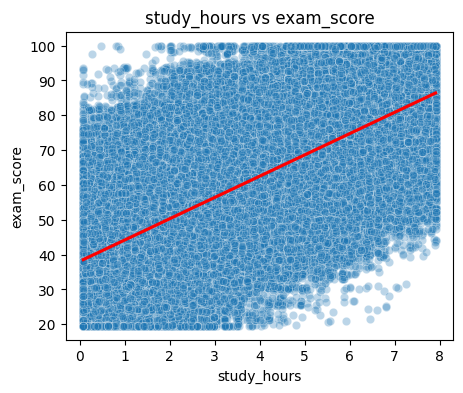

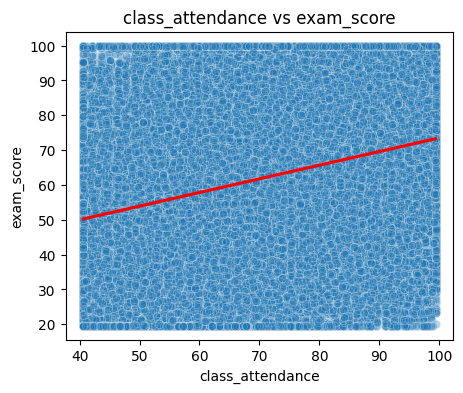

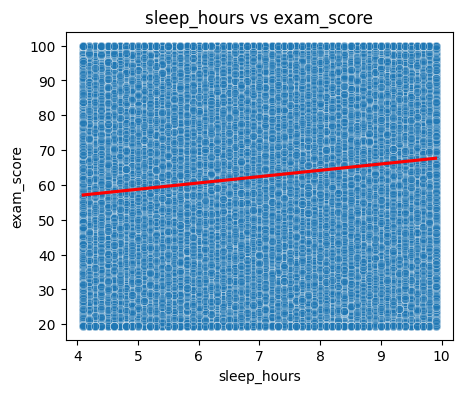

In [46]:
# Feature EDA

# Checking non-linear patterns in numerics

num_cols = ["study_hours", "class_attendance", "sleep_hours"]

for col in num_cols:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=train, x=col, y="exam_score", alpha=0.3)
    sns.regplot(data=train, x=col, y="exam_score", scatter=False, color="red")
    plt.title(f"{col} vs exam_score")
    plt.show()


C:\Users\james\AppData\Local\Temp\ipykernel_27336\4279226270.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = train.pivot_table(


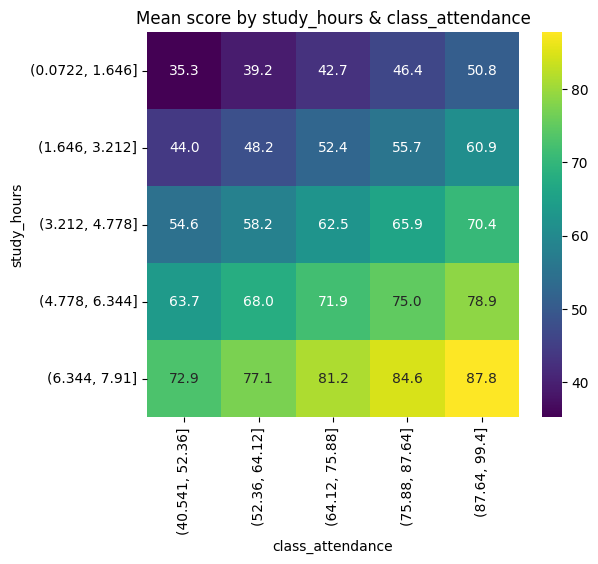

In [51]:
pivot = train.pivot_table(
    values="exam_score",
    index=pd.cut(train["study_hours"], bins=5),
    columns=pd.cut(train["class_attendance"], bins=5),
    aggfunc="mean"
)

plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis")
plt.title("Mean score by study_hours & class_attendance")
plt.show()


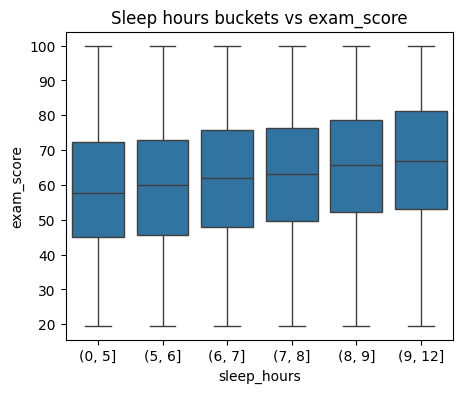

In [52]:
plt.figure(figsize=(5,4))
sns.boxplot(data=train, x=pd.cut(train["sleep_hours"], bins=[0,5,6,7,8,9,12]), y="exam_score")
plt.title("Sleep hours buckets vs exam_score")
plt.show()


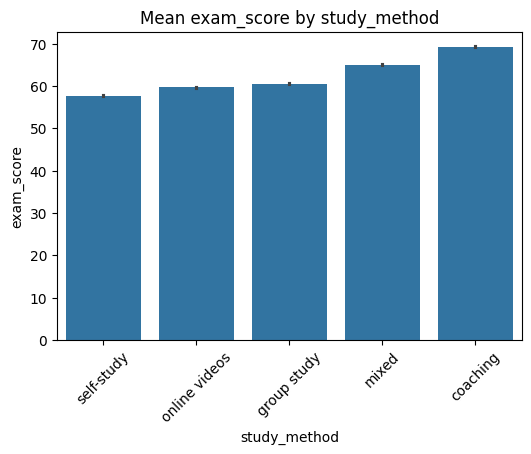

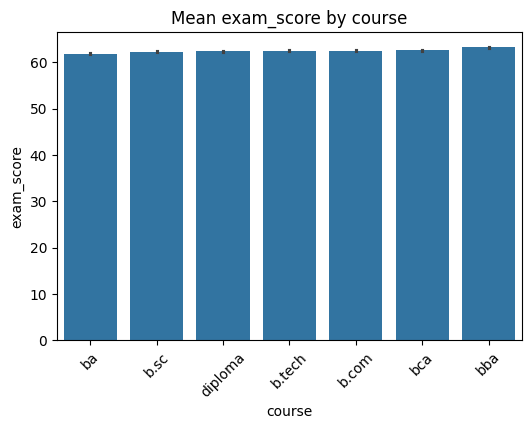

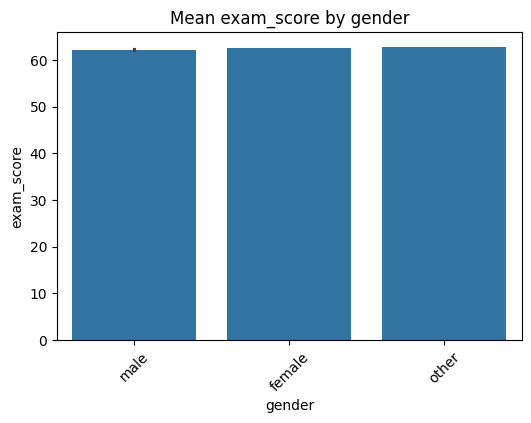

In [53]:
cat_cols = ["study_method", "course", "gender"]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    order = train.groupby(col)["exam_score"].mean().sort_values().index
    sns.barplot(data=train, x=col, y="exam_score", order=order)
    plt.title(f"Mean exam_score by {col}")
    plt.xticks(rotation=45)
    plt.show()


# Testing 3 different model varients

In [62]:
# LightGBM with monotonic constraints

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMRegressor

# --- Feature engineering ---
sleep_map = {"poor": 1, "average": 2, "good": 3}
facility_map = {"low": 1, "medium": 2, "high": 3}
difficulty_map = {"easy": 1, "moderate": 2, "hard": 3}

def add_features(df):
    df = df.copy()
    df["age"] = df["age"].astype(str)

    df["sleep_quality_num"] = df["sleep_quality"].map(sleep_map)
    df["facility_rating_num"] = df["facility_rating"].map(facility_map)
    df["exam_difficulty_num"] = df["exam_difficulty"].map(difficulty_map)

    df["effort_index"] = df["study_hours"] * df["class_attendance"]
    df["sleep_score"] = df["sleep_hours"] * df["sleep_quality_num"]
    df["preparedness"] = df["study_hours"] * df["facility_rating_num"]
    df["effort_vs_difficulty"] = df["study_hours"] / (df["exam_difficulty_num"] + 1)

    return df

feature_engineer = FunctionTransformer(add_features, validate=False)

# --- Columns ---
ordinal_cols = ["sleep_quality", "facility_rating", "exam_difficulty"]
ordinal_categories = [
    ["poor", "average", "good"],
    ["low", "medium", "high"],
    ["easy", "moderate", "hard"]
]

cat_cols = ["gender", "course", "study_method", "internet_access", "age"]

num_cols = [
    "study_hours", "class_attendance", "sleep_hours",
    "sleep_quality_num", "facility_rating_num", "exam_difficulty_num",
    "effort_index", "sleep_score", "preparedness", "effort_vs_difficulty"
]

preprocess = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# --- Fit once to get feature names for constraints ---
temp_pipe = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("preprocess", preprocess)
])
temp_pipe.fit(X, y)
feature_names = temp_pipe.named_steps["preprocess"].get_feature_names_out()

mono_features = {
    "study_hours",
    "class_attendance",
    "sleep_hours",
    "sleep_quality_num",
    "facility_rating_num",
    "effort_index",
    "sleep_score",
    "preparedness",
    "effort_vs_difficulty"
}

constraints = []
for name in feature_names:
    # mark numeric/engineered monotonic features
    if any(name.endswith(f) for f in mono_features):
        constraints.append(1)
    else:
        constraints.append(0)

# --- Model with monotonic constraints ---
mono_model = LGBMRegressor(
    colsample_bytree=0.8,
    learning_rate=0.03,
    max_depth=8,
    min_child_samples=40,
    n_estimators=800,
    num_leaves=127,
    subsample=0.8,
    monotone_constraints=constraints,
    random_state=42
)

mono_clf = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("preprocess", preprocess),
    ("model", mono_model)
])

# --- CV ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(mono_clf, X, y, scoring="neg_root_mean_squared_error", cv=cv)
rmse_scores = -scores
rmse_scores, rmse_scores.mean(), rmse_scores.std()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.482335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.502155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.523833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.522425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.502613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(array([8.8917576 , 8.89879106, 8.88475645, 8.8950612 , 8.91656811]),
 np.float64(8.897386882246561),
 np.float64(0.010644404164116274))

### Monotonic model hurt performance so we drop this

In [56]:
# Drop low‑signal categoricals (gender + course)

cat_cols_reduced = [
    "study_method", "internet_access", "age",
    "study_hours_bin", "sleep_hours_bin"
]

preprocess_reduced = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_reduced),
        ("num", "passthrough", num_cols)
    ]
)

lgbm_model = LGBMRegressor(
    colsample_bytree=0.8,
    learning_rate=0.03,
    max_depth=8,
    min_child_samples=40,
    n_estimators=800,
    num_leaves=127,
    subsample=0.8,
    random_state=42
)

reduced_clf = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("preprocess", preprocess_reduced),
    ("model", lgbm_model)
])

scores = cross_val_score(reduced_clf, X, y, scoring="neg_root_mean_squared_error", cv=cv)
rmse = -scores
rmse.mean(), rmse.std()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.482335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.502155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.523833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.522425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 38
[LightGBM] [Info] Start training from score 62.502613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(np.float64(8.753400889609551), np.float64(0.013714214742589019))

## (np.float64(8.753400889609551), np.float64(0.013714214742589019))

In [63]:
# Residual modeling (2‑stage)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Cache pipeline steps to speed up preprocessing
memory = joblib.Memory(location=".cache", verbose=0)

stage1 = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
], memory=memory)

oof_pred = np.zeros(len(X))

for train_idx, valid_idx in kf.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

    stage1.fit(X_tr, y_tr)
    oof_pred[valid_idx] = stage1.predict(X_val)

residuals = y - oof_pred


# Stage 2: LGBM on residuals
stage2 = Pipeline(steps=[
    ("feature_engineer", feature_engineer),
    ("preprocess", preprocess),
    ("model", LGBMRegressor(
        colsample_bytree=0.8,
        learning_rate=0.03,
        max_depth=8,
        min_child_samples=40,
        n_estimators=800,
        num_leaves=127,
        subsample=0.8,
        random_state=42
    ))
])

# Evaluate stage2 with CV on residuals
residual_scores = []
for train_idx, valid_idx in kf.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = residuals.iloc[train_idx], residuals.iloc[valid_idx]

    stage2.fit(X_tr, y_tr)
    pred_resid = stage2.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred_resid))
    residual_scores.append(rmse)

np.mean(residual_scores), np.std(residual_scores)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 420000, number of used features: 38
[LightGBM] [Info] Start training from score -0.001107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 420000, number of used features: 38
[LightGBM] [Info] Start training from score 0.005189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 420000, number of used features: 38
[LightGBM] [Info] Start training from score -0.004313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(np.float64(8.752720812574779), np.float64(0.010705315536765167))

### Performed the same as Lgbm

---

### I will tune a CatBoost model

This model may perform better than our best Lgbm model as its more suited to catagorical data

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools

cat_cols = X.select_dtypes(include=["object", "category"]).columns
cat_features = [X.columns.get_loc(c) for c in cat_cols]

param_grid = {
    "iterations": [400, 800],
    "learning_rate": [0.03, 0.05, 0.1],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

best_rmse = float("inf")
best_params = None

for params in itertools.product(
    param_grid["iterations"],
    param_grid["learning_rate"],
    param_grid["depth"],
    param_grid["l2_leaf_reg"]
):
    iters, lr, depth, l2 = params
    rmses = []
    for train_idx, valid_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostRegressor(
            iterations=iters,
            learning_rate=lr,
            depth=depth,
            l2_leaf_reg=l2,
            loss_function="RMSE",
            random_state=42,
            verbose=0
        )
        model.fit(X_tr, y_tr, cat_features=cat_features)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmses.append(rmse)

    mean_rmse = np.mean(rmses)
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = {
            "iterations": iters,
            "learning_rate": lr,
            "depth": depth,
            "l2_leaf_reg": l2
        }
        print("New best:", best_rmse, best_params)

best_rmse, best_params
